In [227]:
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from envs.fx_triplet_env import FXTripletEnv, FXTripletConfig
import os
import math
import random
from collections import deque, namedtuple
from dataclasses import dataclass
from typing import Tuple, Optional, List, Dict
import numpy as np
import matplotlib.pyplot as plt

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.tensorboard import SummaryWriter
except Exception as e:
    raise ImportError("PyTorch is required for this DDQN implementation."
        "Install it before running this cell. Example (CPU-only):\n"
        "  pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu\n"
        "or see https://pytorch.org/get-started/locally/ for the correct command for environment."
    )

## Config for DDQN training

In [229]:
@dataclass
class DDQNConfig:
    # trading
    seed: int = 0
    total_episodes: int = 500
    max_steps_per_episode: int = 10
    batch_size: int = 64
    buffer_size: int = 10000
    gamma: float = 0.999
    lr: float = 1e-4
    target_update_freq: int = 100      # in gradient steps
    start_training_after: int = 500    # steps to fill replay before training
    train_frequency: int = 1           # train every N steps
    epsilon_start: float = 1.0
    epsilon_final: float = 0.01
    epsilon_decay_steps: int = 20000   # linear decay steps
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    save_path: str = "./ddqn_checkpoints"
    log_dir:str = "./ddqn_logs"

## Replay Buffer

In [180]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity: int, seed: Optional[int] = None):
        self.capacity = int(capacity)
        self.buffer = deque(maxlen = self.capacity)
        self.rng = random.Random(seed)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size: int):
        batch = self.rng.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

## Q-network (simple MLP)

In [182]:
class MLPNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes: List[int] = [64,64]):
        super().__init__()
        layers = []
        in_dim = state_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, action_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)

## DDQN Agent

In [184]:
class DDQNAgent:
    def __init__(self,
                 env,
                 cfg: DDQNConfig,
                 hidden_sizes: List[int] = [64, 64],
                 discrete_action_table: Optional[np.array] = None):
        """
        env: gym-like env implementing Step 1
        cfg: DDQNConfig dataclass
        discrete_action_table: if env uses discrete actions, provide mapping array (n_actions, 3)
        """
        self.env = env
        self.cfg = cfg
        self.rng = np.random.default_rng(cfg.seed)
        self.device = torch.device(cfg.device)
        # determine state / action dims
        self.state_dim = int(np.prod(env.observation_space.shape))
        # For discrete actions, the agent acts over ints 0..n-1
        if isinstance(env.action_space, gym.spaces.Discrete):
            # discrete
            self.discrete = True
            self.n_actions = int(env.action_space.n)
            self.action_dim = self.n_actions
            if discrete_action_table is None:
                self.discrete_action_table = getattr(env, "_action_table", None)
            else:
                self.discrete_action_table = discrete_action_table
        else:
            self.discrete = False
            # continuous actions: discretize to N bins per dimension for DDQN baseline if needed
            # But paper uses DDQN with a small discrete action set; here I assume env.action_space is Discrete for DDQN.
            raise ValueError("DDQN baseline expects a discrete action space in the env. for continous, discrete first")
        # networks
        self.policy_net = MLPNetwork(self.state_dim, self.action_dim, hidden_sizes).to(self.device)
        self.target_net = MLPNetwork(self.state_dim, self.action_dim, hidden_sizes).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # optimizer & buffer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
        self.replay = ReplayBuffer(cfg.buffer_size, seed=cfg.seed)
        self.total_steps = 0
        self.train_steps = 0

        # epsilon schedule params
        self.epsilon = cfg.epsilon_start
        self.epsilon_decay = (cfg.epsilon_start - cfg.epsilon_final) / float(max(1, cfg.epsilon_decay_steps))

        # logging
        os.makedirs(cfg.save_path, exist_ok=True)
        os.makedirs(cfg.log_dir, exist_ok=True)
        self.writer = SummaryWriter(cfg.log_dir)

    def select_action(self, state: np.ndarray, eval_mode: bool = False) -> int:
        """
        state: np.ndarray shaped like env.observation_space
        returns: integer action (index into discrete action table)
        """
        if not eval_mode and self.rng.random() < self.epsilon:
            return int(self.rng.integers(0, self.action_dim))
        # else greedy
        state_t = torch.tensor(state, dtype = torch.float32, device = self.device).unsqueeze(0)
        with torch.no_grad():
            qvals = self.policy_net(state_t)
            action = int(torch.argmax(qvals, dim = 1).cpu().item())
        return action

    def push_transition(self, state, action, reward, next_state, done):
        self.replay.push(state.astype(np.float32), int(action), float(reward), next_state.astype(np.float32), bool(done))

    def _compute_td_loss(self, batch: Transition) -> torch.Tensor:
        states = torch.tensor(np.stack(batch.state), dtype=torch.float32, device=self.device)
        actions = torch.tensor(batch.action, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(np.stack(batch.next_state), dtype=torch.float32, device=self.device)
        dones = torch.tensor(batch.done, dtype=torch.float32, device=self.device).unsqueeze(1)

        # current Q(s, a)
        q_values = self.policy_net(states).gather(1, actions)

        # Double DQN target: I used policy_net to choose argmax action, target_net to eval
        with torch.no_grad():
            next_q_policy = self.policy_net(next_states)
            next_actions = torch.argmax(next_q_policy, dim=1, keepdim=True)
            next_q_target = self.target_net(next_states).gather(1, next_actions)
            td_target = rewards + (1.0 - dones) * (self.cfg.gamma * next_q_target)

        loss = nn.MSELoss()(q_values, td_target)
        return loss
    
    def train_step(self):
        # ensuring enough samples
        if len(self.replay) < max(self.cfg.batch_size, 1):
            return None
        batch = self.replay.sample(self.cfg.batch_size)
        loss = self._compute_td_loss(batch)
        self.optimizer.zero_grad()
        loss.backward()
        
        # gradient clipping for stability
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10.0)
        self.optimizer.step()
        self.train_steps += 1
        
        # target network update
        if (self.train_steps % self.cfg.target_update_freq) == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        return float(loss.item())
    
    def decay_epsilon(self):
        if self.epsilon > self.cfg.epsilon_final:
            self.epsilon -= self.epsilon_decay
            if self.epsilon < self.cfg.epsilon_final:
                self.epsilon = self.cfg.epsilon_final
    
    def save(self, tag: str = "latest"):
        path = os.path.join(self.cfg.save_path, f"ddqn_{tag}.pth")
        torch.save({
            "policy_state_dict": self.policy_net.state_dict(),
            "target_state_dict": self.target_net.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "cfg": self.cfg,
        }, path)
        print(f"Saved model to {path}")
    
    def load(self, path: str):
        data = torch.load(path, map_location=self.device)
        self.policy_net.load_state_dict(data["policy_state_dict"])
        self.target_net.load_state_dict(data["target_state_dict"])
        if "optimizer_state_dict" in data:
            try:
                self.optimizer.load_state_dict(data["optimizer_state_dict"])
            except Exception:
                print("Could not load optimizer state (shapes mismatch). Continuing without loading optimizer state")
        print(f"Loaded model from {path}")
    
    def action_index_to_env_action(self, index: int) -> np.ndarray:
        if self.discrete_action_table is None:
            raise RuntimeError("No discrete action table available to map index to environment action")
        return np.array(self.discrete_action_table[int(index)], dtype=np.float32)

    # Full training loop (episodic)
    def train(self,
              save_every_episodes: int = 50,
              eval_every_episodes: int = 50,
              eval_episodes: int = 10,
              verbose: bool = True):
        total_steps = 0
        episode_rewards = []
        for episode in range(1, self.cfg.total_episodes + 1):
            state = self.env.reset()
            ep_reward = 0.0
            for step in range(self.cfg.max_steps_per_episode):
                # action index selection
                action_idx = self.select_action(state, eval_mode=False)
                # map to env action values
                env_action = self.action_index_to_env_action(action_idx)
                next_state, reward, done, info = self.env.step(env_action)
                self.push_transition(state, action_idx, reward, next_state, done)
                state = next_state
                ep_reward += reward
                total_steps += 1
                # training step
                if total_steps >= self.cfg.start_training_after and (total_steps % self.cfg.train_frequency == 0):
                    loss = self.train_step()
                    if loss is not None:
                        self.writer.add_scalar("train/loss", loss, global_step=total_steps)
                # epsilon decay
                self.decay_epsilon()
                if done:
                    break
            episode_rewards.append(ep_reward)
            self.writer.add_scalar("episode/reward", ep_reward, episode)
            if verbose and (episode % 10 == 0 or episode == 1):
                avg_recent = np.mean(episode_rewards[-50:])
                print(f"Episode {episode}/{self.cfg.total_episodes}   ep_reward={ep_reward:.4f}  eps={self.epsilon:.4f}  avg50={avg_recent:.4f}")
            # save
            if episode % save_every_episodes == 0:
                self.save(tag=f"ep{episode}")
            # eval
            if episode % eval_every_episodes == 0:
                avg_eval = self.evaluate(n_episodes=eval_episodes)
                self.writer.add_scalar("eval/avg_reward", avg_eval, episode)
        # final save
        self.save(tag="final")
        return episode_rewards


    # Evaluation (greedy policy)
    def evaluate(self, n_episodes: int = 10, render: bool = False) -> float:
        old_eps = self.epsilon
        self.epsilon = 0.0  # greedy
        rewards = []
        for ep in range(n_episodes):
            s = self.env.reset()
            ep_r = 0.0
            for _ in range(self.cfg.max_steps_per_episode):
                idx = self.select_action(s, eval_mode=True)
                a = self.action_index_to_env_action(idx)
                s, r, done, _ = self.env.step(a)
                ep_r += r
                if render:
                    self.env.render()
                if done:
                    break
            rewards.append(ep_r)
        self.epsilon = old_eps
        avg = float(np.mean(rewards))
        print(f"Evaluation over {n_episodes} episodes: avg_reward={avg:.6f}")
        return avg

## Full training loop (episodic)


In [186]:
def train(self,
        save_every_episodes: int = 50,
        eval_every_episodes: int = 50,
        eval_episodes: int = 10,
        verbose: bool = True):
    total_steps = 0
    episode_rewards = []
    for episode in range(1, self.cfg.total_episodes + 1):
        state = self.env.reset()
        ep_reward = 0.0
        for step in range(self.cfg.max_steps_per_episode):
            # action index selection
            action_idx = self.select_action(state, eval_mode=False)
            # map to env action values
            env_action = self.action_index_to_env_action(action_idx)
            next_state, reward, done, info = self.env.step(env_action)
            self.push_transition(state, action_idx, reward, next_state, done)
            state = next_state
            ep_reward += reward
            total_steps += 1
            # training step
            if total_steps >= self.cfg.start_training_after and (total_steps % self.cfg.train_frequency == 0):
                loss = self.train_step()
                if loss is not None:
                    self.writer.add_scalar("train/loss", loss, global_step=total_steps)
            # epsilon decay
            self.decay_epsilon()
            if done:
                break
        episode_rewards.append(ep_reward)
        self.writer.add_scalar("episode/reward", ep_reward, episode)
        if verbose and (episode % 10 == 0 or episode == 1):
            avg_recent = np.mean(episode_rewards[-50:])
            print(f"Episode {episode}/{self.cfg.total_episodes}   ep_reward={ep_reward:.4f}  eps={self.epsilon:.4f}  avg50={avg_recent:.4f}")
        # save
        if episode % save_every_episodes == 0:
            self.save(tag=f"ep{episode}")
        # eval
        if episode % eval_every_episodes == 0:
            avg_eval = self.evaluate(n_episodes=eval_episodes)
            self.writer.add_scalar("eval/avg_reward", avg_eval, episode)
        # final save
        self.save(tag="final")
        return episode_rewards

    # Evaluation (greedy policy)
    def evaluate(self, n_episodes: int = 10, render: bool = False) -> float:
        old_eps = self.epsilon
        self.epsilon = 0.0  # greedy
        rewards = []
        for ep in range(n_episodes):
            s = self.env.reset()
            ep_r = 0.0
            for _ in range(self.cfg.max_steps_per_episode):
                idx = self.select_action(s, eval_mode=True)
                a = self.action_index_to_env_action(idx)
                s, r, done, _ = self.env.step(a)
                ep_r += r
                if render:
                    self.env.render()
                if done:
                    break
            rewards.append(ep_r)
        self.epsilon = old_eps
        avg = float(np.mean(rewards))
        print(f"Evaluation over {n_episodes} episodes: avg_reward={avg:.6f}")
        return avg

## Evaluation (greedy policy)

In [188]:
"""
def evaluate(self, n_episodes: int = 10, render: bool = False) -> float:
        old_eps = self.epsilon
        self.epsilon = 0.0  # greedy
        rewards = []
        for ep in range(n_episodes):
            s = self.env.reset()
            ep_r = 0.0
            for _ in range(self.cfg.max_steps_per_episode):
                idx = self.select_action(s, eval_mode=True)
                a = self.action_index_to_env_action(idx)
                s, r, done, _ = self.env.step(a)
                ep_r += r
                if render:
                    self.env.render()
                if done:
                    break
            rewards.append(ep_r)
        self.epsilon = old_eps
        avg = float(np.mean(rewards))
        print(f"Evaluation over {n_episodes} episodes: avg_reward={avg:.6f}")
        return avg"""

'\ndef evaluate(self, n_episodes: int = 10, render: bool = False) -> float:\n        old_eps = self.epsilon\n        self.epsilon = 0.0  # greedy\n        rewards = []\n        for ep in range(n_episodes):\n            s = self.env.reset()\n            ep_r = 0.0\n            for _ in range(self.cfg.max_steps_per_episode):\n                idx = self.select_action(s, eval_mode=True)\n                a = self.action_index_to_env_action(idx)\n                s, r, done, _ = self.env.step(a)\n                ep_r += r\n                if render:\n                    self.env.render()\n                if done:\n                    break\n            rewards.append(ep_r)\n        self.epsilon = old_eps\n        avg = float(np.mean(rewards))\n        print(f"Evaluation over {n_episodes} episodes: avg_reward={avg:.6f}")\n        return avg'

## creation of an action table for DDQN using env._action_table as per availablity

In [190]:
def make_discrete_table_from_env(env, max_grid_per_dim=5):
    """
    If env has an _action_table attribute, return it.
    Otherwise, build a coarse grid over 3 dims with max_grid_per_dim values per dimension.
    """
    if hasattr(env, "_action_table") and env._action_table is not None:
        return np.array(env._action_table)
    # try to inspect action bounds
    assert hasattr(env, "cfg"), "Env must expose cfg with min_trade/max_trade"
    minv = env.cfg.min_trade
    maxv = env.cfg.max_trade
    grid = np.linspace(minv, maxv, max_grid_per_dim)
    combos = np.array(np.meshgrid(grid, grid, grid)).T.reshape(-1,3)
    # optionally prune duplicates or too many combos
    # choose a subset
    n = min(len(combos), 125)  # cap to 125
    idx = np.linspace(0, len(combos)-1, n).astype(int)
    return combos[idx].astype(np.float32)

## Smoke-test routine (small run)

In [192]:
def ddqn_smoke_test():
    print("Running DDQN smoke test (very small training run)...")
    # create env if not in global scope
    try:
        env  # check if env exists
    except NameError:
        # require user to define env in notebook
        raise RuntimeError("Please ensure FXTripletEnv from Step 1 is defined and 'env' is instantiated in the notebook scope before running this smoke test.")
    # wrap up
    cfg = DDQNConfig(total_episodes=20, max_steps_per_episode=env.cfg.T, buffer_size=2000, start_training_after=20, epsilon_decay_steps=1000)
    disc_table = make_discrete_table_from_env(env, max_grid_per_dim=3)
    agent = DDQNAgent(env, cfg, hidden_sizes=[64,64], discrete_action_table=disc_table)
    # run training for a few episodes
    rewards = agent.train(save_every_episodes=10, eval_every_episodes=10, eval_episodes=3, verbose=True)
    print("Smoke test completed. Sample rewards:", rewards[:5])
    return agent, rewards
# agent, rewards = ddqn_smoke_test()

In [223]:
cfg_env = FXTripletConfig(
    seed=0,
    discrete_action=True,
    n_discrete=125
)
env = FXTripletEnv(cfg_env)

cfg = DDQNConfig(
    total_episodes=2000, 
    max_steps_per_episode=env.cfg.T, 
    buffer_size=50000,
    batch_size = 64,
    start_training_after=1000,
    train_frequency=1,               # update every step
    target_update_freq=500,          # slower target updates
    epsilon_start=1.0,               # full exploration
    epsilon_final=0.05,              # still some exploration at the end
    epsilon_decay_steps=20000,
    seed=0
)

agent = DDQNAgent(env, cfg, hidden_sizes=[128,128])
rewards = agent.train(save_every_episodes=100, eval_every_episodes=50, eval_episodes=10, verbose=True)
print(env.action_space)

Episode 1/2000   ep_reward=-20.7218  eps=0.9995  avg50=-20.7218
Episode 10/2000   ep_reward=-7.3526  eps=0.9953  avg50=-10.5352
Episode 20/2000   ep_reward=-13.2742  eps=0.9905  avg50=-11.5995
Episode 30/2000   ep_reward=-13.7848  eps=0.9858  avg50=-11.6794
Episode 40/2000   ep_reward=-0.7469  eps=0.9810  avg50=-13.2729
Episode 50/2000   ep_reward=-25.0618  eps=0.9763  avg50=-14.2149
Evaluation over 10 episodes: avg_reward=-156.043839
Episode 60/2000   ep_reward=-2.6770  eps=0.9715  avg50=-14.8217
Episode 70/2000   ep_reward=-0.7618  eps=0.9668  avg50=-14.2075
Episode 80/2000   ep_reward=-3.9934  eps=0.9620  avg50=-14.0919
Episode 90/2000   ep_reward=-70.5474  eps=0.9573  avg50=-13.4457
Episode 100/2000   ep_reward=-44.1889  eps=0.9525  avg50=-13.7499
Saved model to ./ddqn_checkpoints\ddqn_ep100.pth
Evaluation over 10 episodes: avg_reward=-155.957245
Episode 110/2000   ep_reward=-12.1454  eps=0.9478  avg50=-12.6462
Episode 120/2000   ep_reward=-25.6958  eps=0.9430  avg50=-15.3723
Episo

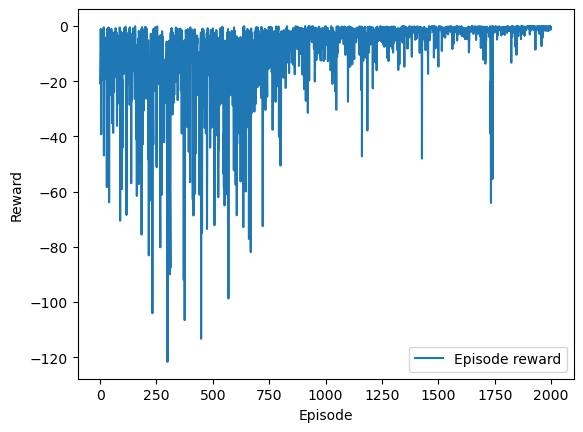

In [231]:
plt.plot(rewards, label="Episode reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()